In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [3]:
train_gen=ImageDataGenerator(rescale=1/255.0,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
train_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Disease Detection/OriginalDataset', 
                                        target_size= (128, 128),
                                       class_mode = 'categorical', 
                                       batch_size = 32, 
                                       shuffle = True,
                                       subset='training')
test_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Disease Detection/OriginalDataset', 
                                        target_size= (128, 128),
                                        class_mode = 'categorical', 
                                        batch_size = 32, 
                                        shuffle = True,
                                        subset='validation')

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


<ipython-input-12-a0e4d55ae275>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,5,1),plt.imshow(DATA[0][3]),plt.subplot(2,5,4),plt.imshow(DATA[0][4]),plt.subplot(2,5,5),plt.imshow(DATA[0][5])


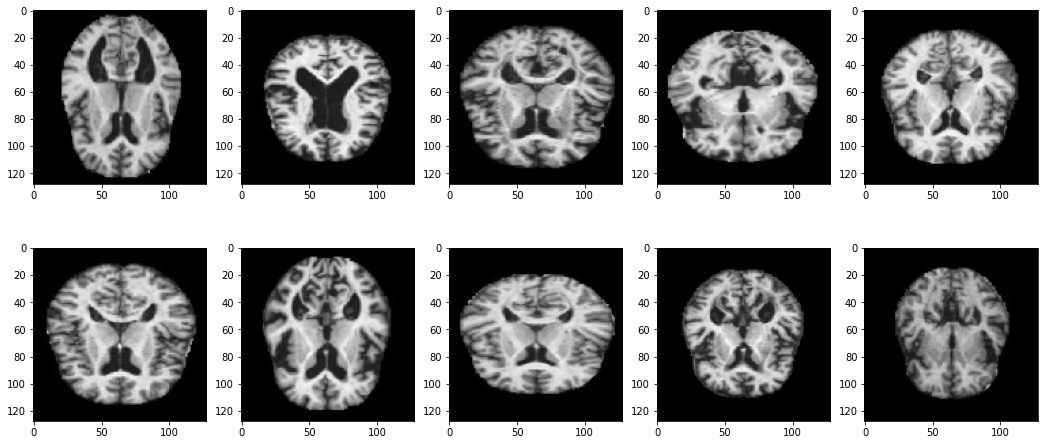

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcd17427190>,
 None)

In [12]:
DATA=next(iter(train_data))
plt.rcParams['figure.figsize']=(18,8)
plt.subplot(2,5,1),plt.imshow(DATA[0][0]),plt.subplot(2,5,2),plt.imshow(DATA[0][1]),plt.subplot(2,5,3),plt.imshow(DATA[0][2])
plt.subplot(2,5,1),plt.imshow(DATA[0][3]),plt.subplot(2,5,4),plt.imshow(DATA[0][4]),plt.subplot(2,5,5),plt.imshow(DATA[0][5])
plt.subplot(2,5,6),plt.imshow(DATA[0][6]),plt.subplot(2,5,7),plt.imshow(DATA[0][7]),plt.subplot(2,5,8),plt.imshow(DATA[0][8])
plt.subplot(2,5,9),plt.imshow(DATA[0][9]),plt.subplot(2,5,10),plt.imshow(DATA[0][10]),plt.show()

## Or

In [3]:
from sklearn.utils import shuffle
DATA=[]
for i,folder in enumerate(os.listdir('/content/drive/MyDrive/Alzheimer Disease Detection/OriginalDataset')):
  for image in os.listdir(f'/content/drive/MyDrive/Alzheimer Disease Detection/OriginalDataset/{folder}')[:500]:
    img=cv2.imread(f'/content/drive/MyDrive/Alzheimer Disease Detection/OriginalDataset/{folder}/{image}')
    img=cv2.resize(img,(128,128))/255.0
    DATA.append((img,i))
DATA=np.array(shuffle(DATA))
Images=np.array([i for i in DATA[:,0]]).reshape((1564,128,128,3))
Labels=DATA[:,1].astype(np.float32)

<ipython-input-3-aa5805c10996>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA=np.array(shuffle(DATA))


In [4]:
x_train,x_test,y_train,y_test=Images[:1200],Images[1200:],Labels[:1200],Labels[1200:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1200, 128, 128, 3), (364, 128, 128, 3), (1200,), (364,))

In [63]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,4)
y_test=to_categorical(y_test,4)
y_train.shape

(1200, 4)

## Deep Learning Model

In [19]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
SEEDS = 42
np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

In [42]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = 10
NUM_CLASSES = 4  

In [43]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [52]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.Before_Head = keras.layers.Dense(256,activation='relu')
        self.head = keras.layers.Dense(num_classes,activation='sigmoid')
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(self.Before_Head(bit_embedding))

model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [53]:
learning_rate = 0.003 * BATCH_SIZE / 512
SCHEDULE_BOUNDARIES = [200,300,400]  # more the dataset size the schedule length increase
                                              # Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.CategoricalCrossentropy()

In [54]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Recall(),keras.metrics.Precision()])
train_callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)]

In [55]:
history = model.fit(x_train,y_train,epochs=50,batch_size=32,validation_data=(x_test,y_test),callbacks=train_callbacks)

Epoch 1/50
37/38 [============================>.] - ETA: 0s - loss: 1.9080 - categorical_accuracy: 0.4443 - recall_6: 0.9341 - precision_6: 0.2985

38/38 [==============================] - 8s 132ms/step - loss: 1.8955 - categorical_accuracy: 0.4458 - recall_6: 0.9350 - precision_6: 0.2982 - val_loss: 1.0702 - val_categorical_accuracy: 0.5357 - val_recall_6: 0.9918 - val_precision_6: 0.2940
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 1.1067 - categorical_accuracy: 0.5557 - recall_6: 0.9848 - precision_6: 0.2813

38/38 [==============================] - 4s 99ms/step - loss: 1.1039 - categorical_accuracy: 0.5567 - recall_6: 0.9850 - precision_6: 0.2816 - val_loss: 1.3268 - val_categorical_accuracy: 0.5137 - val_recall_6: 0.9835 - val_precision_6: 0.2889
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.9511 - categorical_accuracy: 0.6067 - recall_6: 0.9950 - precision_6: 0.2837

38/38 [==============================] - 4s 100ms/step - loss: 0.9511 - categorical_accuracy: 0.6067 - recall_6: 0.9950 - precision_6: 0.2837 - val_loss: 0.9372 - val_categorical_accuracy: 0.6154 - val_recall_6: 1.0000 - val_precision_6: 0.2787
Epoch 4/50
37/38 [============================>.] - ETA: 0s - loss: 0.9128 - categorical_accuracy: 0.6157 - recall_6: 0.9975 - precision_6: 0.2893

38/38 [==============================] - 4s 103ms/step - loss: 0.9188 - categorical_accuracy: 0.6133 - recall_6: 0.9975 - precision_6: 0.2895 - val_loss: 1.0916 - val_categorical_accuracy: 0.5769 - val_recall_6: 0.9945 - val_precision_6: 0.3019
Epoch 5/50
38/38 [==============================] - ETA: 0s - loss: 0.9446 - categorical_accuracy: 0.6058 - recall_6: 0.9917 - precision_6: 0.3016

38/38 [==============================] - 4s 100ms/step - loss: 0.9446 - categorical_accuracy: 0.6058 - recall_6: 0.9917 - precision_6: 0.3016 - val_loss: 0.7965 - val_categorical_accuracy: 0.6456 - val_recall_6: 0.9973 - val_precision_6: 0.3100
Epoch 6/50
37/38 [============================>.] - ETA: 0s - loss: 0.8258 - categorical_accuracy: 0.6529 - recall_6: 0.9958 - precision_6: 0.2885

38/38 [==============================] - 4s 100ms/step - loss: 0.8255 - categorical_accuracy: 0.6525 - recall_6: 0.9958 - precision_6: 0.2884 - val_loss: 0.8192 - val_categorical_accuracy: 0.6511 - val_recall_6: 0.9918 - val_precision_6: 0.2964
Epoch 7/50
37/38 [============================>.] - ETA: 0s - loss: 0.7295 - categorical_accuracy: 0.6774 - recall_6: 0.9983 - precision_6: 0.2963

38/38 [==============================] - 4s 100ms/step - loss: 0.7272 - categorical_accuracy: 0.6783 - recall_6: 0.9983 - precision_6: 0.2964 - val_loss: 0.7680 - val_categorical_accuracy: 0.6731 - val_recall_6: 0.9973 - val_precision_6: 0.2963
Epoch 8/50
37/38 [============================>.] - ETA: 0s - loss: 0.7110 - categorical_accuracy: 0.7027 - recall_6: 0.9983 - precision_6: 0.2929

38/38 [==============================] - 4s 100ms/step - loss: 0.7111 - categorical_accuracy: 0.7025 - recall_6: 0.9983 - precision_6: 0.2928 - val_loss: 0.7681 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.2970
Epoch 9/50
37/38 [============================>.] - ETA: 0s - loss: 0.7058 - categorical_accuracy: 0.7171 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 100ms/step - loss: 0.7051 - categorical_accuracy: 0.7175 - recall_6: 0.9983 - precision_6: 0.2948 - val_loss: 0.7640 - val_categorical_accuracy: 0.6731 - val_recall_6: 0.9945 - val_precision_6: 0.2989
Epoch 10/50
37/38 [============================>.] - ETA: 0s - loss: 0.6944 - categorical_accuracy: 0.7120 - recall_6: 0.9983 - precision_6: 0.2947

38/38 [==============================] - 4s 100ms/step - loss: 0.6955 - categorical_accuracy: 0.7083 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7604 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.2992
Epoch 11/50
37/38 [============================>.] - ETA: 0s - loss: 0.6962 - categorical_accuracy: 0.7069 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 100ms/step - loss: 0.6947 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2946 - val_loss: 0.7596 - val_categorical_accuracy: 0.6813 - val_recall_6: 0.9945 - val_precision_6: 0.2987
Epoch 12/50
37/38 [============================>.] - ETA: 0s - loss: 0.6947 - categorical_accuracy: 0.7061 - recall_6: 0.9983 - precision_6: 0.2946

38/38 [==============================] - 4s 100ms/step - loss: 0.6938 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2946 - val_loss: 0.7595 - val_categorical_accuracy: 0.6731 - val_recall_6: 0.9945 - val_precision_6: 0.2987
Epoch 13/50
37/38 [============================>.] - ETA: 0s - loss: 0.6920 - categorical_accuracy: 0.7078 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 100ms/step - loss: 0.6937 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2946 - val_loss: 0.7595 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2987
Epoch 14/50
37/38 [============================>.] - ETA: 0s - loss: 0.6952 - categorical_accuracy: 0.7061 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 99ms/step - loss: 0.6935 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2947 - val_loss: 0.7595 - val_categorical_accuracy: 0.6731 - val_recall_6: 0.9945 - val_precision_6: 0.2989
Epoch 15/50
37/38 [============================>.] - ETA: 0s - loss: 0.6964 - categorical_accuracy: 0.7044 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 99ms/step - loss: 0.6934 - categorical_accuracy: 0.7058 - recall_6: 0.9983 - precision_6: 0.2946 - val_loss: 0.7595 - val_categorical_accuracy: 0.6731 - val_recall_6: 0.9945 - val_precision_6: 0.2989
Epoch 16/50
37/38 [============================>.] - ETA: 0s - loss: 0.6916 - categorical_accuracy: 0.7095 - recall_6: 0.9983 - precision_6: 0.2944

38/38 [==============================] - 4s 99ms/step - loss: 0.6934 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2947 - val_loss: 0.7594 - val_categorical_accuracy: 0.6731 - val_recall_6: 0.9945 - val_precision_6: 0.2989
Epoch 17/50
37/38 [============================>.] - ETA: 0s - loss: 0.6931 - categorical_accuracy: 0.7052 - recall_6: 0.9983 - precision_6: 0.2945

38/38 [==============================] - 4s 99ms/step - loss: 0.6932 - categorical_accuracy: 0.7058 - recall_6: 0.9983 - precision_6: 0.2947 - val_loss: 0.7594 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2992
Epoch 18/50
37/38 [============================>.] - ETA: 0s - loss: 0.6902 - categorical_accuracy: 0.7095 - recall_6: 0.9983 - precision_6: 0.2951

38/38 [==============================] - 4s 98ms/step - loss: 0.6932 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2947 - val_loss: 0.7594 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2992
Epoch 19/50
37/38 [============================>.] - ETA: 0s - loss: 0.6928 - categorical_accuracy: 0.7069 - recall_6: 0.9983 - precision_6: 0.2947

38/38 [==============================] - 4s 99ms/step - loss: 0.6931 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7594 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2992
Epoch 20/50
37/38 [============================>.] - ETA: 0s - loss: 0.6935 - categorical_accuracy: 0.7061 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 99ms/step - loss: 0.6931 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2948 - val_loss: 0.7594 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2992
Epoch 21/50
37/38 [============================>.] - ETA: 0s - loss: 0.6957 - categorical_accuracy: 0.7078 - recall_6: 0.9983 - precision_6: 0.2942

38/38 [==============================] - 4s 99ms/step - loss: 0.6930 - categorical_accuracy: 0.7083 - recall_6: 0.9983 - precision_6: 0.2947 - val_loss: 0.7594 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2992
Epoch 22/50
37/38 [============================>.] - ETA: 0s - loss: 0.6883 - categorical_accuracy: 0.7095 - recall_6: 0.9992 - precision_6: 0.2946

38/38 [==============================] - 4s 99ms/step - loss: 0.6930 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2948 - val_loss: 0.7593 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2992
Epoch 23/50
37/38 [============================>.] - ETA: 0s - loss: 0.6943 - categorical_accuracy: 0.7061 - recall_6: 0.9983 - precision_6: 0.2951

38/38 [==============================] - 4s 99ms/step - loss: 0.6929 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7593 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2992
Epoch 24/50
37/38 [============================>.] - ETA: 0s - loss: 0.6924 - categorical_accuracy: 0.7069 - recall_6: 0.9983 - precision_6: 0.2951

38/38 [==============================] - 4s 99ms/step - loss: 0.6928 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7593 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2994
Epoch 25/50
37/38 [============================>.] - ETA: 0s - loss: 0.6920 - categorical_accuracy: 0.7086 - recall_6: 0.9983 - precision_6: 0.2945

38/38 [==============================] - 4s 98ms/step - loss: 0.6928 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7593 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2992
Epoch 26/50
37/38 [============================>.] - ETA: 0s - loss: 0.6912 - categorical_accuracy: 0.7086 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 99ms/step - loss: 0.6928 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7592 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2997
Epoch 27/50
37/38 [============================>.] - ETA: 0s - loss: 0.6913 - categorical_accuracy: 0.7052 - recall_6: 0.9983 - precision_6: 0.2949

38/38 [==============================] - 4s 99ms/step - loss: 0.6927 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7593 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.2997
Epoch 28/50
37/38 [============================>.] - ETA: 0s - loss: 0.6949 - categorical_accuracy: 0.7044 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 99ms/step - loss: 0.6926 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7592 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.2997
Epoch 29/50
37/38 [============================>.] - ETA: 0s - loss: 0.6909 - categorical_accuracy: 0.7078 - recall_6: 0.9983 - precision_6: 0.2946

38/38 [==============================] - 4s 100ms/step - loss: 0.6926 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2948 - val_loss: 0.7591 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.2997
Epoch 30/50
37/38 [============================>.] - ETA: 0s - loss: 0.6941 - categorical_accuracy: 0.7052 - recall_6: 0.9983 - precision_6: 0.2945

38/38 [==============================] - 4s 100ms/step - loss: 0.6926 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7592 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.2997
Epoch 31/50
37/38 [============================>.] - ETA: 0s - loss: 0.6925 - categorical_accuracy: 0.7078 - recall_6: 0.9983 - precision_6: 0.2949

38/38 [==============================] - 4s 99ms/step - loss: 0.6925 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2948 - val_loss: 0.7590 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.2997
Epoch 32/50
37/38 [============================>.] - ETA: 0s - loss: 0.6928 - categorical_accuracy: 0.7052 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 99ms/step - loss: 0.6925 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7591 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.2997
Epoch 33/50
37/38 [============================>.] - ETA: 0s - loss: 0.6879 - categorical_accuracy: 0.7103 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 99ms/step - loss: 0.6924 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2948 - val_loss: 0.7590 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.2997
Epoch 34/50
37/38 [============================>.] - ETA: 0s - loss: 0.6962 - categorical_accuracy: 0.7061 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 99ms/step - loss: 0.6924 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7590 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3002
Epoch 35/50
37/38 [============================>.] - ETA: 0s - loss: 0.6953 - categorical_accuracy: 0.7052 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 99ms/step - loss: 0.6923 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7589 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3002
Epoch 36/50
37/38 [============================>.] - ETA: 0s - loss: 0.6907 - categorical_accuracy: 0.7061 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 100ms/step - loss: 0.6923 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2948 - val_loss: 0.7588 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3002
Epoch 37/50
37/38 [============================>.] - ETA: 0s - loss: 0.6925 - categorical_accuracy: 0.7061 - recall_6: 0.9983 - precision_6: 0.2947

38/38 [==============================] - 4s 99ms/step - loss: 0.6922 - categorical_accuracy: 0.7058 - recall_6: 0.9983 - precision_6: 0.2950 - val_loss: 0.7589 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3002
Epoch 38/50
37/38 [============================>.] - ETA: 0s - loss: 0.6950 - categorical_accuracy: 0.7035 - recall_6: 0.9983 - precision_6: 0.2954

38/38 [==============================] - 4s 100ms/step - loss: 0.6922 - categorical_accuracy: 0.7058 - recall_6: 0.9983 - precision_6: 0.2950 - val_loss: 0.7589 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3002
Epoch 39/50
37/38 [============================>.] - ETA: 0s - loss: 0.6935 - categorical_accuracy: 0.7044 - recall_6: 0.9983 - precision_6: 0.2950

38/38 [==============================] - 4s 101ms/step - loss: 0.6921 - categorical_accuracy: 0.7058 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7588 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.2999
Epoch 40/50
37/38 [============================>.] - ETA: 0s - loss: 0.6883 - categorical_accuracy: 0.7103 - recall_6: 0.9983 - precision_6: 0.2948

38/38 [==============================] - 4s 102ms/step - loss: 0.6921 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2949 - val_loss: 0.7588 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3002
Epoch 41/50
37/38 [============================>.] - ETA: 0s - loss: 0.6888 - categorical_accuracy: 0.7078 - recall_6: 0.9992 - precision_6: 0.2951

38/38 [==============================] - 4s 100ms/step - loss: 0.6920 - categorical_accuracy: 0.7058 - recall_6: 0.9983 - precision_6: 0.2950 - val_loss: 0.7589 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3004
Epoch 42/50
37/38 [============================>.] - ETA: 0s - loss: 0.6941 - categorical_accuracy: 0.7061 - recall_6: 0.9983 - precision_6: 0.2949

38/38 [==============================] - 4s 99ms/step - loss: 0.6920 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2950 - val_loss: 0.7588 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3004
Epoch 43/50
37/38 [============================>.] - ETA: 0s - loss: 0.6934 - categorical_accuracy: 0.7044 - recall_6: 0.9983 - precision_6: 0.2950

38/38 [==============================] - 4s 100ms/step - loss: 0.6920 - categorical_accuracy: 0.7058 - recall_6: 0.9983 - precision_6: 0.2950 - val_loss: 0.7587 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3007
Epoch 44/50
37/38 [============================>.] - ETA: 0s - loss: 0.6926 - categorical_accuracy: 0.7069 - recall_6: 0.9983 - precision_6: 0.2950

38/38 [==============================] - 4s 99ms/step - loss: 0.6919 - categorical_accuracy: 0.7058 - recall_6: 0.9983 - precision_6: 0.2950 - val_loss: 0.7586 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.3004
Epoch 45/50
37/38 [============================>.] - ETA: 0s - loss: 0.6924 - categorical_accuracy: 0.7052 - recall_6: 0.9983 - precision_6: 0.2951

38/38 [==============================] - 4s 100ms/step - loss: 0.6918 - categorical_accuracy: 0.7058 - recall_6: 0.9983 - precision_6: 0.2951 - val_loss: 0.7587 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3004
Epoch 46/50
37/38 [============================>.] - ETA: 0s - loss: 0.6962 - categorical_accuracy: 0.7035 - recall_6: 0.9983 - precision_6: 0.2946

38/38 [==============================] - 4s 100ms/step - loss: 0.6918 - categorical_accuracy: 0.7067 - recall_6: 0.9983 - precision_6: 0.2950 - val_loss: 0.7587 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3004
Epoch 47/50
37/38 [============================>.] - ETA: 0s - loss: 0.6907 - categorical_accuracy: 0.7069 - recall_6: 0.9983 - precision_6: 0.2953

38/38 [==============================] - 4s 99ms/step - loss: 0.6918 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2951 - val_loss: 0.7587 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3007
Epoch 48/50
37/38 [============================>.] - ETA: 0s - loss: 0.6946 - categorical_accuracy: 0.7069 - recall_6: 0.9983 - precision_6: 0.2947

38/38 [==============================] - 4s 99ms/step - loss: 0.6918 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2951 - val_loss: 0.7585 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.3012
Epoch 49/50
37/38 [============================>.] - ETA: 0s - loss: 0.6949 - categorical_accuracy: 0.7061 - recall_6: 0.9983 - precision_6: 0.2955

38/38 [==============================] - 4s 99ms/step - loss: 0.6916 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2952 - val_loss: 0.7586 - val_categorical_accuracy: 0.6676 - val_recall_6: 0.9945 - val_precision_6: 0.3004
Epoch 50/50
37/38 [============================>.] - ETA: 0s - loss: 0.6922 - categorical_accuracy: 0.7086 - recall_6: 0.9983 - precision_6: 0.2951

38/38 [==============================] - 4s 99ms/step - loss: 0.6917 - categorical_accuracy: 0.7075 - recall_6: 0.9983 - precision_6: 0.2952 - val_loss: 0.7585 - val_categorical_accuracy: 0.6703 - val_recall_6: 0.9945 - val_precision_6: 0.3012


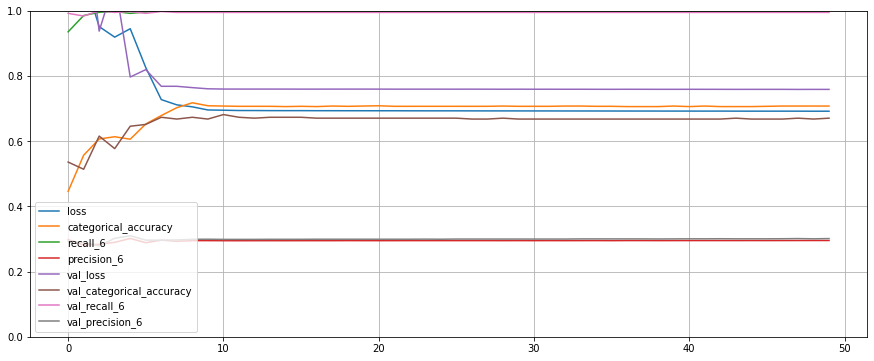

In [56]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [57]:
accuracy = model.evaluate(test_data)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

40/40 [==============================] - 9s 194ms/step - loss: 1.6794 - categorical_accuracy: 0.3557 - recall_6: 1.0000 - precision_6: 0.2647
Accuracy: 35.57%


## Attention Based Deep Multiple Instance Learning (MIL) 

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.style.use("ggplot")

In [35]:
POSITIVE_CLASS = 1
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 2
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

In [36]:
def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):

    # Set up bags.
    bags = []
    bag_labels = []

    # Normalize input data.
    input_data = np.divide(input_data, 255.0)

    # Count positive samples.
    count = 0

    for _ in range(bag_count):

        # Pick a fixed size random subset of samples.
        index = np.random.choice(input_data.shape[0], instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]

        # By default, all bags are labeled as 0.
        bag_label = 0

        # Check if there is at least a positive class in the bag.
        if positive_class in instances_labels:

            # Positive bag will be labeled as 1.
            bag_label = 1
            count += 1

        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))

    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")

    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))


# Create training data.
train_data, train_labels = create_bags(
    x_train*255.0, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE
)

# Create validation data.
val_data, val_labels = create_bags(
    x_test*255.0, y_test, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

Positive bags: 78
Negative bags: 922
Positive bags: 31
Negative bags: 269


In [37]:
class MILAttentionLayer(layers.Layer):
    def __init__(self,weight_params_dim,kernel_initializer="glorot_uniform",kernel_regularizer=None,use_gated=False,**kwargs):
        super().__init__(**kwargs)
        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer
        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer
    def build(self, input_shape):
        input_dim = input_shape[0][1]
        self.v_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim),initializer=self.v_init,name="v",
            regularizer=self.v_regularizer,trainable=True)
        self.w_weight_params = self.add_weight(shape=(self.weight_params_dim, 1),initializer=self.w_init,name="w",
            regularizer=self.w_regularizer,trainable=True)
        if self.use_gated:
            self.u_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim),initializer=self.u_init,name="u",
                regularizer=self.u_regularizer,trainable=True)
        else:
            self.u_weight_params = None
        self.input_built = True
    def call(self, inputs):
        instances = [self.compute_attention_scores(instance) for instance in inputs]
        alpha = tf.math.softmax(instances, axis=0)
        return [alpha[i] for i in range(alpha.shape[0])]
    def compute_attention_scores(self, instance):
        original_instance = instance
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))
        if self.use_gated:instance = instance * tf.math.sigmoid(tf.tensordot(original_instance, self.u_weight_params, axes=1))
        return tf.tensordot(instance, self.w_weight_params, axes=1)

The bag class label is positive
Bag number: 17


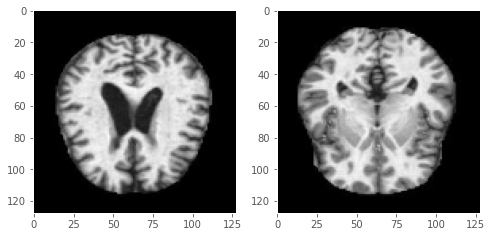

Bag number: 24


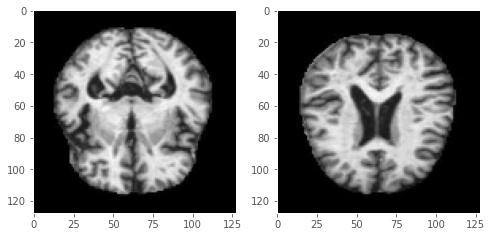

Bag number: 31


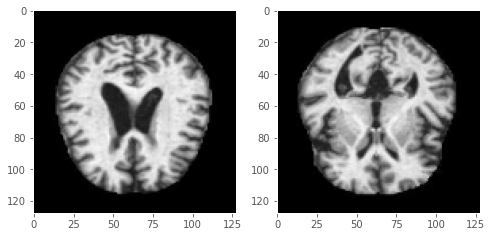

The bag class label is negative
Bag number: 0


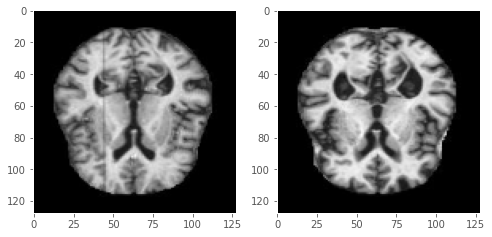

Bag number: 1


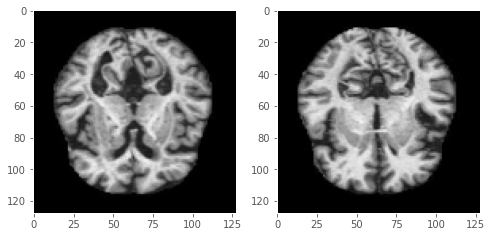

Bag number: 2


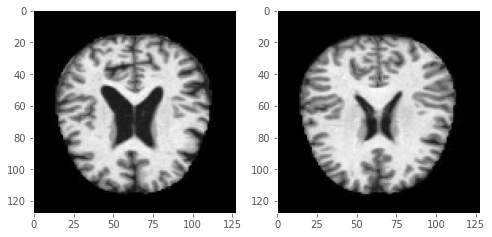

In [38]:
def plot(data, labels, bag_class, predictions=None, attention_weights=None):
    labels = np.array(labels).reshape(-1)
    if bag_class == "positive":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
    elif bag_class == "negative":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
    else:
        print(f"There is no class {bag_class}")
        return
    print(f"The bag class label is {bag_class}")
    for i in range(PLOT_SIZE):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(BAG_SIZE):
            image = bags[j][i]
            figure.add_subplot(1, BAG_SIZE, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                plt.title(np.around(attention_weights[labels[i]][j], 2))
            plt.imshow(image)
        plt.show()
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

In [39]:
def create_model(instance_shape):
    inputs, embeddings = [], []
    shared_dense_layer_1 = layers.Dense(128, activation="relu")
    shared_dense_layer_2 = layers.Dense(64, activation="relu")
    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = shared_dense_layer_1(flatten)
        dense_2 = shared_dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)

    # Invoke the attention layer.
    alpha = MILAttentionLayer(weight_params_dim=256,kernel_regularizer=keras.regularizers.l2(0.01),use_gated=True,name="alpha",
                                                                      )(embeddings)
    # Multiply attention weights with the input layers.
    multiply_layers = [layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))]
    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)
    # Classification output node.
    output = layers.Dense(4, activation="softmax")(concat)
    return keras.Model(inputs, output)

In [40]:
def compute_class_weights(labels):
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

In [41]:
def train(train_data, train_labels, val_data, val_labels, model):
    file_path = "/tmp/best_model_weights.h5"
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        file_path,
        monitor="val_loss",
        verbose=0,
        mode="min",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=20,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0,
    )
    model.load_weights(file_path)
    return model

instance_shape = train_data[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

print(models[0].summary())

# Training model(s).
trained_models = [
    train(train_data, train_labels, val_data, val_labels, model)
    for model in tqdm(models)
]

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 flatten_8 (Flatten)            (None, 49152)        0           ['input_9[0][0]']                
                                                                                            

100%|██████████| 1/1 [02:23<00:00, 143.04s/it]


In [42]:
def predict(data, labels, trained_models):

    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []

    for model in trained_models:

        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)

        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)

        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)

        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)

        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)

    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_AVG_COUNT:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_AVG_COUNT:.2f} % resp."
    )

    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_AVG_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_AVG_COUNT,
    )


# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

10/10 [==============================] - 0s 7ms/step
The average loss and accuracy are 0.06 and 99.00 % resp.


The bag class label is positive
Bag number: 17


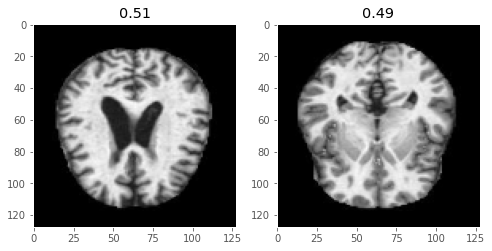

Bag number: 24


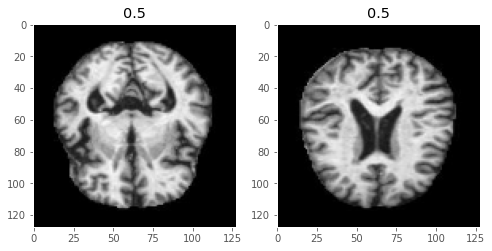

Bag number: 31


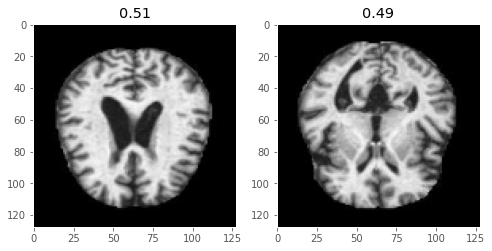

In [43]:
plot(
    val_data,
    val_labels,
    "positive",
    predictions=class_predictions,
    attention_weights=attention_params,
)

The bag class label is negative
Bag number: 0


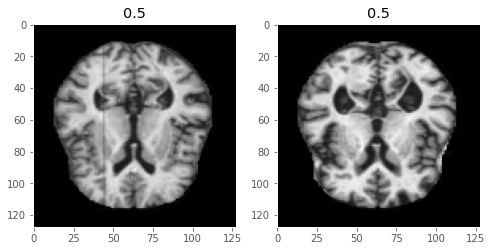

Bag number: 1


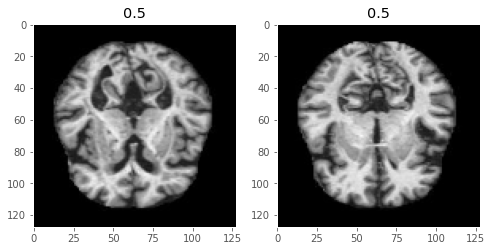

Bag number: 2


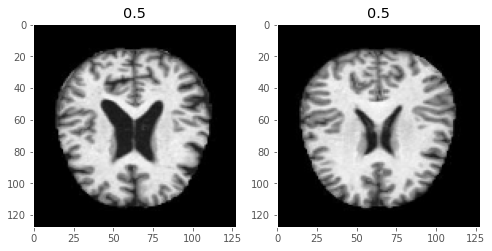

In [44]:
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)

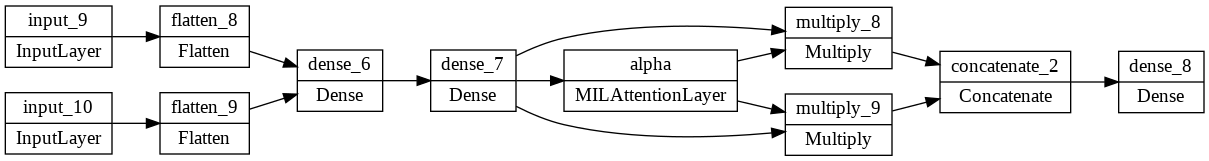

In [46]:
from keras.utils.vis_utils import plot_model
plot_model(models[0],rankdir='LR',to_file='ADMIL.png')

## End